In [1]:
import modules.resnet_3d as resnet
from pathlib import Path
import numpy as np
from modules.mapper import FileMapper as fm
from modules.dataset_with_postop import Dataset
from modules.dataset_image_only_postop import Dataset as dataset_2
from modules.cnn_model import CNNModel
from torch.utils.data import DataLoader
import torchtuples as tt
from pycox.models import LogisticHazard
import pickle
import random
from modules.mlflow_logger import Logger
from modules.utils import getPatientIdentifier, collate_fn, returnMontage, get_optimizer
import sys
import argparse
import datetime
from pycox.evaluation import EvalSurv
from pycox.utils import kaplan_meier
import logging
import logging.config
import pytz
import torch
import plotly.graph_objs as go
# from lifelines import KaplanMeierFitter
import plotly
plotly.offline.init_notebook_mode(connected=True)
import pandas as pd
%load_ext autoreload
%autoreload 2

# Create Dataset

In [2]:
preop_patients = []
for path in Path('./data/preoperative_no_norm').glob('BMIAXNA*'):
    preop_patients.append(path)

In [3]:
postop_patients = []
for path in Path('./data/postoperative_no_norm').glob('BMIAXNA*'):
    postop_patients.append(path)

In [4]:
id_mapping = './data/pickles_jsons/id_surv_mapping_10_groups.json'

In [5]:
mapper_class = fm(preop_patients, id_mapping, normalized=True, postop_path=postop_patients)
mapper_class.generate_mapping()

Number of patients/folders: 1016


In [6]:
dataset = mapper_class.add_postop()

Number of patients with postop added: 644


In [7]:
dataset[3]

{'id': 'BMIAXNAT_S99999',
 'T2w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T2w/BMIAXNAT_E99999_6_T2w.nii.gz',
 'T1c': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T1c/BMIAXNAT_E99999_6_T1c.nii.gz',
 'T1w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T1w/BMIAXNAT_E99999_2_T1w.nii.gz',
 'ENT': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/ENT/BMIAXNAT_E99999_7_ENT.nii.gz',
 'FLR': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/FLR/BMIAXNAT_E99999_5_FLR.nii.gz',
 'surv': 230.0,
 'event': 0,
 'group': 3,
 'postop_T1c': '/home/jovyan/thesis/data/postoperative_no_norm/BMIAXNAT_S99999/postop_T1c/BMIAXNAT_E99999_6_T1c.nii.gz',
 'postop_T2w': '/home/jovyan/thesis/data/postoperative_no_norm/BMIAXNAT_S99999/postop_T2w/BMIAXNAT_E99999_6_T2w.nii.gz',
 'postop_T1w': '/home/jovyan/thesis/data/postoperative_no_norm/BMIAXNAT_S99999/postop_T1w/BMIAXNAT_E99999_2_T1w.nii.gz',
 'postop_FLR': None}

In [8]:
with open('./data/pickles_jsons/filter_ids_v2_all.pkl', 'rb') as file:
    filter_ids = pickle.load(file)
dataset_filtered = [entry for entry in dataset if entry['ENT'] is not None]
dataset_filtered = [entry for entry in dataset_filtered if entry['id'] not in filter_ids]

## Set Random seed and randomize dataset

In [9]:
random.seed(4)
random.shuffle(dataset_filtered)

In [10]:
dataset_filtered[0]

{'id': 'BMIAXNAT_S99999',
 'T2w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T2w/BMIAXNAT_E99999_301_T2w.nii.gz',
 'T1c': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T1c/BMIAXNAT_E99999_301_T1c.nii.gz',
 'T1w': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/T1w/BMIAXNAT_E99999_301_T1w.nii.gz',
 'ENT': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/ENT/BMIAXNAT_E99999_302-MR1_ENT.nii.gz',
 'FLR': '/home/jovyan/thesis/data/preoperative_no_norm/BMIAXNAT_S99999/FLR/BMIAXNAT_E99999_301_FLR.nii.gz',
 'surv': 29.0,
 'event': 1,
 'group': 1,
 'postop_T1w': None,
 'postop_T1c': None,
 'postop_FLR': None,
 'postop_T2w': None}

# Train/Test/Val split datasets

In [11]:
train_dataset = Dataset(dataset_filtered, phase='train', normalize='zscore', size=64)
val_dataset = Dataset(dataset_filtered, phase='val', normalize='zscore', size=64)

Training Size: 711
Validation Size: 101


In [12]:
test_dataset = dataset_2(dataset_filtered, phase='test', normalize='zscore', size=64)

Test Size: 204


# DataLoaders

In [13]:
train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          num_workers=6,
                          shuffle=False,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_dataset,
                        batch_size=64,
                        num_workers=6, shuffle=False,
                        collate_fn=collate_fn)
test_loader = DataLoader(test_dataset,
                         batch_size=204,
                         shuffle=False)

# ResNet-10

In [14]:
cuts = np.array([   0.,   66.,  141.,  208.,  292.,  363.,  449.,  592.,  829., 1785.])

In [15]:
net = resnet.generate_model(model_depth=10,
                        n_classes=10,
                        n_input_channels=8,
                        shortcut_type='B',
                        conv1_t_size=7,
                        conv1_t_stride=1,
                        no_max_pool=False,
                        widen_factor=1.0,
                        dropout=0.7)

# Model

In [16]:
model = LogisticHazard(net, tt.optim.AdamW(decoupled_weight_decay=0.001), duration_index=cuts, device=0)

In [17]:
num_epochs = 100

In [ ]:
log = model.fit_dataloader(train_loader, num_epochs, [tt.cb.EarlyStopping(patience=6)], True, val_dataloader=val_loader)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



0:	:0s / 9m:0s],		train_loss: 2.6238,	val_loss: 19.9124
1:	:59s / 18m:0s],		train_loss: 2.0946,	val_loss: 4.1615
2:	:58s / 26m:58s],		train_loss: 1.9262,	val_loss: 2.4258
3:	:58s / 35m:57s],		train_loss: 1.9025,	val_loss: 2.0691
4:	:56s / 44m:54s],		train_loss: 1.9031,	val_loss: 2.0935
5:	:58s / 53m:52s],		train_loss: 1.9108,	val_loss: 2.0479
6:	:59s / 1h:2m:51s],		train_loss: 1.9099,	val_loss: 2.0201
7:	:58s / 1h:11m:50s],		train_loss: 1.9288,	val_loss: 2.0416
8:	:56s / 1h:20m:46s],		train_loss: 1.8849,	val_loss: 2.1126
9:	:57s / 1h:29m:44s],		train_loss: 1.8653,	val_loss: 2.0745
10:	:59s / 1h:38m:43s],		train_loss: 1.8489,	val_loss: 2.0388
11:	:4s / 1h:47m:48s],		train_loss: 1.8420,	val_loss: 2.0134
12:	:58s / 1h:56m:47s],		train_loss: 1.8711,	val_loss: 2.0494
13:	:58s / 2h:5m:45s],		train_loss: 1.8066,	val_loss: 2.0022
14:	:59s / 2h:14m:44s],		train_loss: 1.8134,	val_loss: 2.0369
15:	:58s / 2h:23m:43s],		train_loss: 1.8197,	val_loss: 2.0435
16:	:0s / 2h:32m:43s],		train_loss: 1.7994

In [43]:
# model.save_model_weights('./Results/Resnet_with_postop_29-11.pt')

# Test predictions

In [37]:
predictions = model.predict_surv_df(test_loader)

In [38]:
targets = dataset_2(dataset_filtered, phase='test', targets=True)[0][0]
events = dataset_2(dataset_filtered, phase='test', targets=True)[0][1]
survs = dataset_2(dataset_filtered, phase='test', targets=True)[0][2]

Test Size: 204
Test Size: 204
Test Size: 204


# Evaluate

In [39]:
ev_test = EvalSurv(predictions, survs, events, 'km')

In [40]:
concordance = ev_test.concordance_td('antolini')
time_grid = np.linspace(0, survs.max())
integrated_brier_score = ev_test.integrated_brier_score(time_grid)

In [49]:
brier_score = ev_test.brier_score(time_grid)

In [41]:
concordance

0.6332688354093603

In [42]:
integrated_brier_score

0.13912636225158298

In [50]:
trace = go.Scatter(x=brier_score.index.tolist(), y=brier_score.values, name='MRI Dataset')
# trace_clinical = go.Scatter(x=brier_score_clinical['Unnamed: 0'].tolist(), y=brier_score_clinical['brier_score'].tolist(), name='Clinical Dataset')
layout_brier = go.Layout(title='Brier score', 
                         title_x=0.5, xaxis_title='Time (days)', 
                         yaxis_title='Brier score',
                        plot_bgcolor='rgb(252, 253, 255)', 
                   xaxis_gridcolor='rgb(245, 242, 240)',
                  yaxis_gridcolor='rgb(245, 242, 240)',
                  yaxis_linecolor="black",
                  xaxis_linecolor="black",
                        xaxis_range=(0,1750),
                        xaxis_tickmode = 'linear',
        xaxis_dtick = 100)
fig_brier = go.Figure([trace], layout=layout_brier)

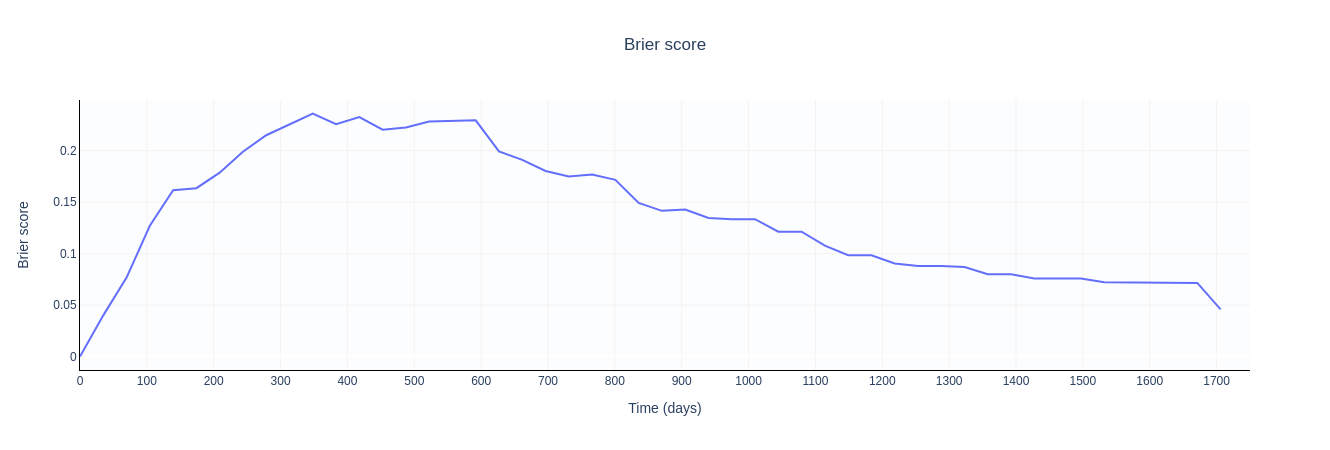

In [51]:
fig_brier

# Average survival curves

In [45]:
group_x = []
group_y = []
for i in range(10):
    idx = targets == i
    group_df = predictions.loc[:, idx].mean(axis=1).rename(i)
    group_x.append(list(group_df.index))
    group_y.append(group_df.values)

In [46]:
colors = ['rgb(166,206,227)','rgb(31,120,180)','rgb(178,223,138)','rgb(51,160,44)','rgb(251,154,153)','rgb(227,26,28)','rgb(253,191,111)','rgb(255,127,0)','rgb(202,178,214)','rgb(106,61,154)']
traces = []
for i in range(10):
    trace = go.Scatter(x=group_x[i], y=group_y[i], mode='lines', line_shape='hv', name='group {}'.format(i), line_color=colors[i], line_width=1.5)
    traces.append(trace)
    
layout = go.Layout(
#     title='Average survival curves per group', 
#     title_x=0.5, 
    xaxis_title='Time (days)', 
    yaxis_title='S(t | x)', 
    plot_bgcolor='rgb(252, 253, 255)', 
    xaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_gridcolor='rgb(245, 242, 240)',
    yaxis_linecolor="black",
    xaxis_linecolor="black",
    xaxis_range=(0, 1800),
    xaxis_tickmode = 'linear',
    xaxis_dtick = 100,
    yaxis_range=(0, 1),
    yaxis_tickmode = 'linear',
    yaxis_dtick = 0.1,
    showlegend=True,
    legend_yanchor="top",
    legend_y = 0.99,
    legend_xanchor="right",
    legend_x=0.99,
    width=500,height=500, autosize=False)
fig = go.Figure(traces, layout=layout)

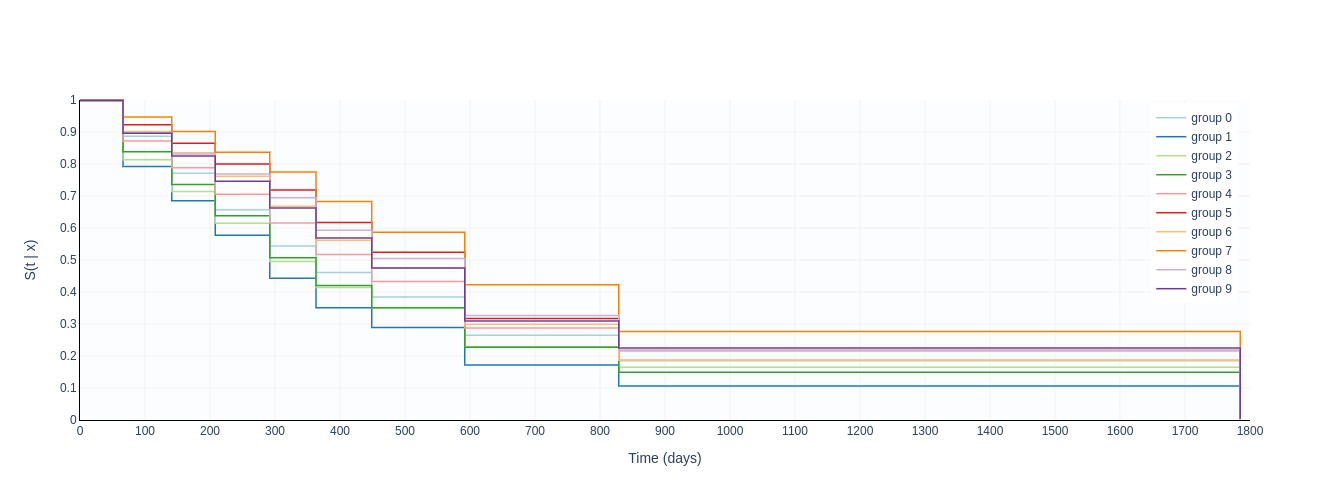

In [47]:
fig

In [24]:
log.to_pandas()

,train_loss,val_loss
0,2.457190,3.246403
1,1.982539,2.411965
2,1.941003,1.977106
3,1.976833,1.996196
4,1.923453,2.091071
5,1.871715,2.048830
6,1.879027,2.038847
7,1.858074,2.023517
